# Garbage classification project pt.2
Using all of the 12 classes, after establishing some baselines on just select 3 classes from the dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
import os

2024-03-23 14:03:49.696849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 14:03:51.613797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/miniconda3/envs/tf/lib
2024-03-23 14:03:51.613888: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/miniconda3/envs/tf/lib
2024-03-23 14:03:51.613895: W tensorflow/compiler/tf2tensorrt/

## Downloading the dataset

In [2]:
# !wget -L "https://drive.google.com/uc?export=download&id=1qoFPTgm4bqfS2kx0luMkMgUs7fKrk376"

In [3]:
# !gdown "https://drive.google.com/uc?export=download&id=1qoFPTgm4bqfS2kx0luMkMgUs7fKrk376"

In [4]:
# %%time
# !unrar x -idp garbage_classification.rar

In [2]:
!ls garbage_classification

/bin/bash: /home/user/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
battery     brown-glass  clothes      metal  plastic  trash
biological  cardboard	 green-glass  paper  shoes    white-glass


## Random seed

In [3]:
tf.random.set_seed(1337)

## Loading the dataset from files

In [4]:
ds_folder = "garbage_classification"

In [5]:
image_size = (256, 256)
batch_size = 32

In [6]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    directory = f"{ds_folder}",
    labels = "inferred",
    color_mode = "rgb",
    subset="both",
    validation_split=0.2,
    shuffle=True,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Using 3103 files for validation.


2024-03-23 14:04:12.371140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 14:04:12.445052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 14:04:12.445096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 14:04:12.448026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [7]:
class_names = train_ds.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


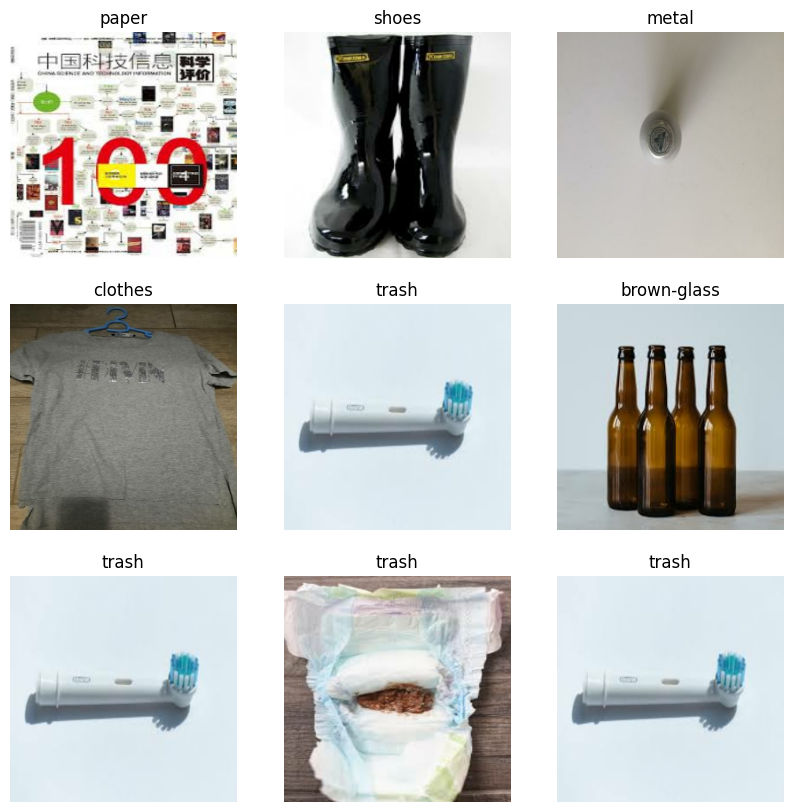

In [9]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    indexes = []
    for _ in range(9):
        indexes.append(random.randint(0, batch_size-1))
    for i, ind in enumerate(indexes):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(np.array(images[ind]).astype("uint8"))
        plt.title(class_names[int(labels[ind])])
        plt.axis("off")

In [10]:
tf.data.experimental.cardinality(train_ds).numpy()

388

388 batches of data, wow

## Data augmentation setup

In [11]:
for folder in os.listdir(f"./{ds_folder}"):
    # file_count = len([name for name in os.listdir(f'./garbage_classification/{folder}') if os.path.isfile(name)])
    file_count = len(os.listdir(f'./garbage_classification/{folder}'))
    print(f'{folder} class count: {file_count}')

battery class count: 945
biological class count: 985
brown-glass class count: 607
cardboard class count: 891
clothes class count: 5325
green-glass class count: 629
metal class count: 769
paper class count: 1050
plastic class count: 865
shoes class count: 1977
trash class count: 697
white-glass class count: 775



It would seem the 'clothes' class seems to heavily (over 5x) overrepresent the dataset, which, on the other hand might make sense, as the class includes multiple articles of clothes, which can vary significantly (think shoes vs shirts vs pants).

Other than that, the data could always use some augmentation, as in simulating taking the photos of the images from different angles, in different circumstances.

In [12]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomBrightness(factor=0.1),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=0.1)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

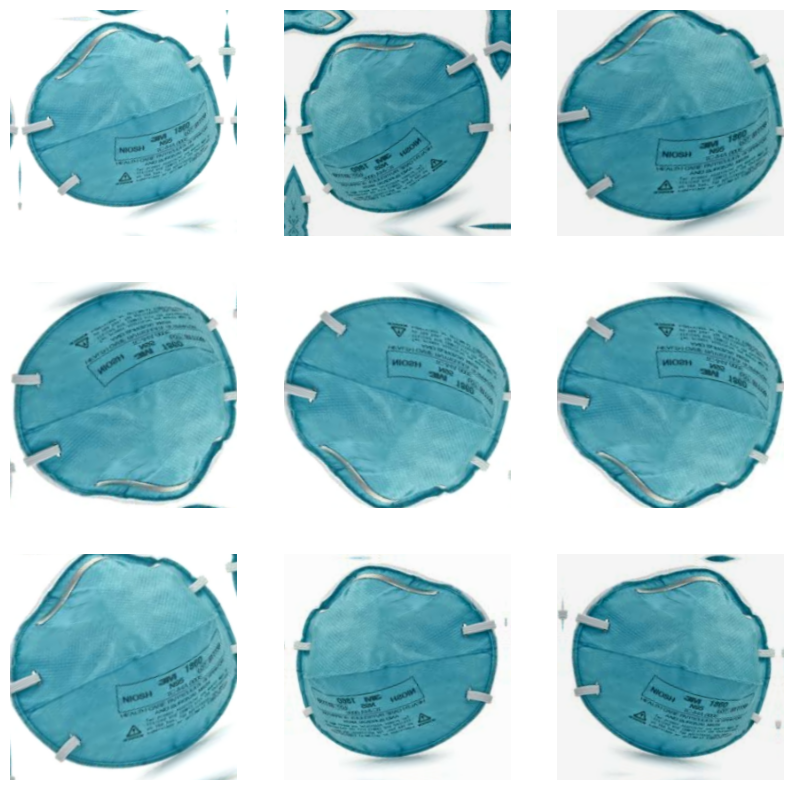

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [14]:
# Apply `data_augmentation` to the training images.
train_ds_aug = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds_aug = train_ds_aug.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Modelling

### Simple conv model unaugmented data

In [15]:
num_classes = len(class_names)

In [16]:
model_small = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(filters=64,  kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64,  kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64,  kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes),
    layers.Softmax()
])

In [17]:
model_small.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    min_delta = 0.01,
    patience = 5,
    verbose = 0,
    restore_best_weights=True
)

In [19]:
callbacks = [
    # keras.callbacks.ModelCheckpoint("three_batchnorm_at_{epoch}.keras"),
    early_stop
]

In [20]:
epochs = 25

In [21]:
# history = model_small.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=epochs,
#     # callbacks = callbacks
# )

<Axes: >

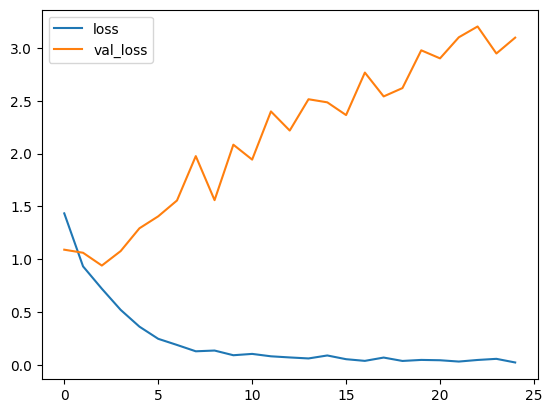

In [29]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

<Axes: >

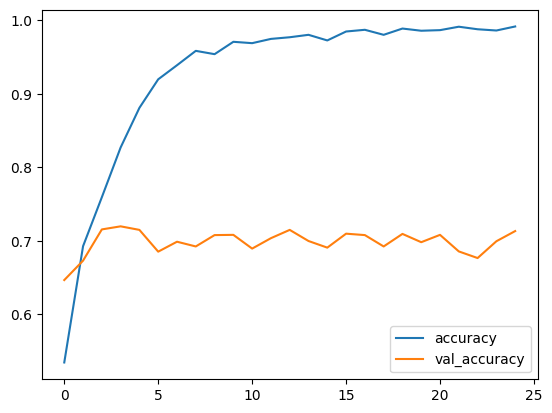

In [30]:
history_df[['accuracy', 'val_accuracy']].plot()

## Evaluation metrics

In [25]:
# sklearn classification metrics
from sklearn.metrics  import (f1_score ,accuracy_score, confusion_matrix,
                            classification_report, ConfusionMatrixDisplay, 
                            roc_curve, precision_recall_curve,
                            auc, make_scorer, recall_score, accuracy_score, precision_score
                            )

97/97 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

     battery       0.70      0.50      0.59       212
  biological       0.76      0.69      0.72       188
 brown-glass       0.70      0.54      0.61       118
   cardboard       0.60      0.69      0.64       203
     clothes       0.85      0.95      0.90      1059
 green-glass       0.77      0.88      0.82       116
       metal       0.38      0.31      0.34       158
       paper       0.64      0.70      0.67       202
     plastic       0.56      0.46      0.51       185
       shoes       0.59      0.60      0.60       379
       trash       0.71      0.58      0.64       136
 white-glass       0.58      0.52      0.54       147

    accuracy                           0.71      3103
   macro avg       0.65      0.62      0.63      3103
weighted avg       0.70      0.71      0.70      3103



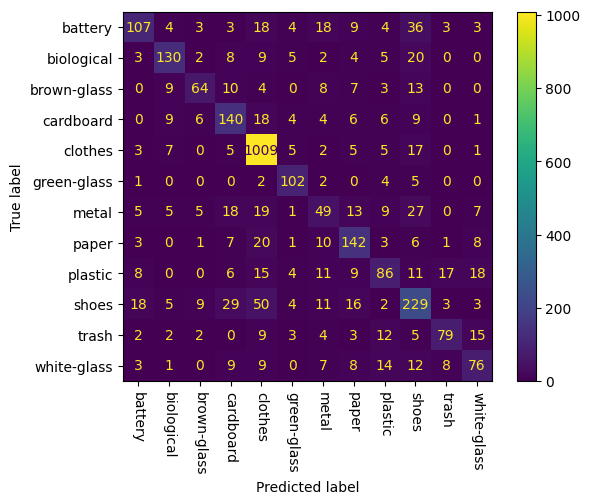

In [31]:
test_preds = model_small.predict(val_ds)
test_labels = np.concatenate([y for x,y in val_ds], axis=0)
test_preds_argmax = test_preds.argmax(axis=1)

nn_clf_report = classification_report(test_labels, test_preds_argmax, target_names = class_names)
print(nn_clf_report)

nn_cm = confusion_matrix(test_labels, test_preds_argmax)
nn_cm_disp = ConfusionMatrixDisplay(nn_cm, display_labels = class_names)
nn_cm_disp.plot(xticks_rotation=-90)

The results? okay, but quite far from perfect

## Transfer learning
starting with EfficientNetB0, as it is easily accessible in keras

In [49]:
from keras.applications.efficientnet_v2 import EfficientNetV2B0

In [50]:
image_size = (224, 224)
batch_size = 32

In [24]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    directory = f"{ds_folder}",
    labels = "inferred",
    color_mode = "rgb",
    subset="both",
    validation_split=0.2,
    shuffle=True,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Using 3103 files for validation.


### preprocessing for EfficientNet (OHEncoding the labels?)

In [25]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    # image = img_augmentation(image)
    label = tf.one_hot(int(label), num_classes)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(int(label), num_classes)
    return image, label


train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.batch(batch_size=batch_size, drop_remainder=True)

### from pre-trained weights

In [26]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 12)


In [27]:
IMG_SIZE = 224
num_classes = 12
NUM_CLASSES = 12

In [51]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [52]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
# plot_hist(hist)

24274472/24274472 [==============================] - 1s 0us/step
Epoch 1/10


2024-03-23 14:35:02.777114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


388/388 [==============================] - 26s 57ms/step - loss: 0.6542 - accuracy: 0.8938 - val_loss: 0.4495 - val_accuracy: 0.9294
Epoch 2/10
388/388 [==============================] - 20s 52ms/step - loss: 0.4634 - accuracy: 0.9294 - val_loss: 0.3595 - val_accuracy: 0.9481
Epoch 3/10
388/388 [==============================] - 21s 53ms/step - loss: 0.4055 - accuracy: 0.9362 - val_loss: 0.3678 - val_accuracy: 0.9549
Epoch 4/10
388/388 [==============================] - 21s 53ms/step - loss: 0.3473 - accuracy: 0.9446 - val_loss: 0.3880 - val_accuracy: 0.9526
Epoch 5/10
388/388 [==============================] - 21s 53ms/step - loss: 0.3675 - accuracy: 0.9467 - val_loss: 0.3954 - val_accuracy: 0.9494
Epoch 6/10
388/388 [==============================] - 20s 52ms/step - loss: 0.3413 - accuracy: 0.9468 - val_loss: 0.3808 - val_accuracy: 0.9513
Epoch 7/10
388/388 [==============================] - 20s 52ms/step - loss: 0.3515 - accuracy: 0.9483 - val_loss: 0.4307 - val_accuracy: 0.9517
Epo

In [30]:
# sklearn classification metrics
from sklearn.metrics  import (f1_score ,accuracy_score, confusion_matrix,
                            classification_report, ConfusionMatrixDisplay, 
                            roc_curve, precision_recall_curve,
                            auc, make_scorer, recall_score, accuracy_score, precision_score
                            )

<Axes: >

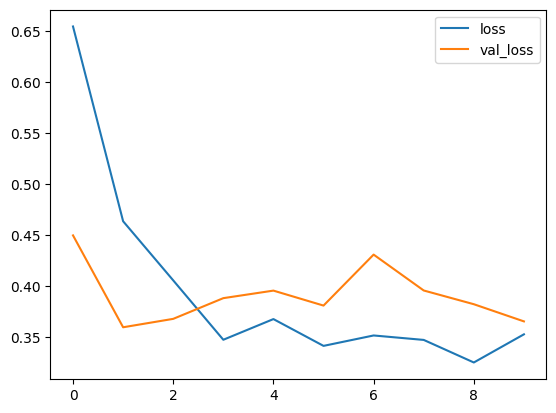

In [53]:
history_df = pd.DataFrame(hist.history)
history_df[['loss', 'val_loss']].plot()

<Axes: >

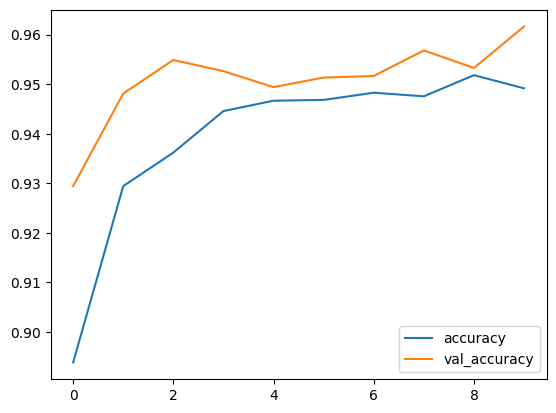

In [54]:
history_df[['accuracy', 'val_accuracy']].plot()

In [55]:
class_names = ['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [56]:
test_preds = model.predict(val_ds)
test_labels = np.concatenate([y for x,y in val_ds], axis=0)
test_preds_argmax = test_preds.argmax(axis=1)

97/97 [==============================] - 4s 36ms/step


In [57]:
test_preds

array([[4.6812477e-21, 4.0463500e-16, 1.9925074e-19, ..., 1.0000000e+00,
        2.5093233e-23, 5.9627943e-27],
       [7.3498738e-21, 2.2408214e-23, 1.4986049e-20, ..., 1.0000000e+00,
        6.9111371e-26, 1.1178051e-21],
       [8.6776837e-16, 5.8558610e-18, 2.1320758e-21, ..., 9.5435278e-15,
        1.5923176e-23, 2.2444438e-20],
       ...,
       [1.0000000e+00, 6.4017353e-19, 6.1450888e-18, ..., 2.3855156e-15,
        5.1511851e-19, 1.5692557e-19],
       [2.6119226e-23, 2.0740445e-21, 3.2495049e-27, ..., 9.2459533e-15,
        6.1764193e-17, 8.9721292e-21],
       [3.7870869e-21, 1.5954883e-12, 1.4825371e-19, ..., 1.6540654e-20,
        1.8415286e-22, 1.9348413e-10]], dtype=float32)

In [58]:
test_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [59]:
test_labels.argmax(axis=1)

array([9, 9, 4, ..., 0, 4, 3])

In [60]:
test_preds_argmax

array([9, 9, 4, ..., 0, 4, 3])

              precision    recall  f1-score   support

     battery       0.96      0.99      0.97       212
  biological       0.95      0.99      0.97       188
 brown-glass       0.96      0.92      0.94       118
   cardboard       0.99      0.95      0.97       203
     clothes       0.99      0.99      0.99      1059
 green-glass       0.97      0.97      0.97       116
       metal       0.90      0.89      0.89       158
       paper       0.96      0.93      0.94       202
     plastic       0.88      0.85      0.87       185
       shoes       0.98      0.98      0.98       379
       trash       0.93      1.00      0.96       136
 white-glass       0.84      0.88      0.86       147

    accuracy                           0.96      3103
   macro avg       0.94      0.95      0.94      3103
weighted avg       0.96      0.96      0.96      3103



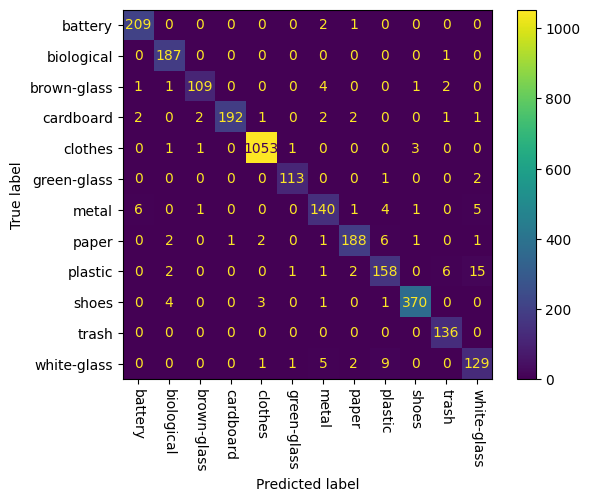

In [61]:
nn_clf_report = classification_report(test_labels.argmax(axis=1), test_preds_argmax, target_names = class_names)
print(nn_clf_report)

nn_cm = confusion_matrix(test_labels.argmax(axis=1), test_preds_argmax)
nn_cm_disp = ConfusionMatrixDisplay(nn_cm, display_labels = class_names)
nn_cm_disp.plot(xticks_rotation=-90)

Almost 95% accuracy, wow. The only class that stands out with a slightly worse performance seems to be the 'metal' class - sometimes confused for batteries - understandable, given batteries' metallic casings and plastic - potentially also understandable through similiaritires between plastic bottles and metal cans, potential shine etc.

In [62]:
model.save('garbage_efficient.keras')

In [63]:
loaded_model = tf.keras.models.load_model('garbage_efficient.keras')

In [66]:
loaded_model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  0          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                       

In [64]:
test_preds = loaded_model.predict(val_ds)
test_labels = np.concatenate([y for x,y in val_ds], axis=0)
test_preds_argmax = test_preds.argmax(axis=1)

97/97 [==============================] - 4s 38ms/step


              precision    recall  f1-score   support

     battery       0.96      0.99      0.97       212
  biological       0.95      0.99      0.97       188
 brown-glass       0.96      0.92      0.94       118
   cardboard       0.99      0.95      0.97       203
     clothes       0.99      0.99      0.99      1059
 green-glass       0.97      0.97      0.97       116
       metal       0.90      0.89      0.89       158
       paper       0.96      0.93      0.94       202
     plastic       0.88      0.85      0.87       185
       shoes       0.98      0.98      0.98       379
       trash       0.93      1.00      0.96       136
 white-glass       0.84      0.88      0.86       147

    accuracy                           0.96      3103
   macro avg       0.94      0.95      0.94      3103
weighted avg       0.96      0.96      0.96      3103



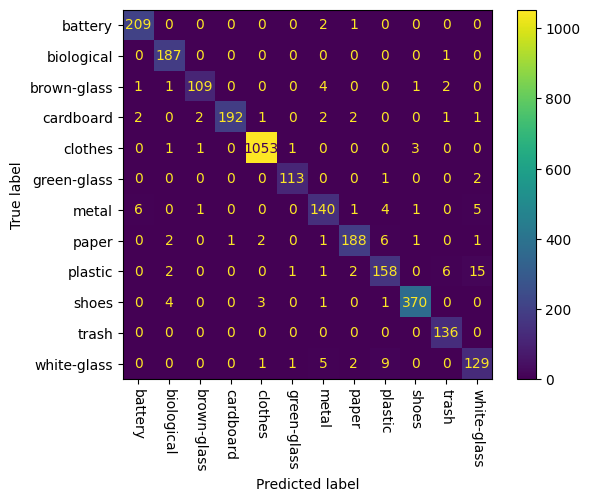

In [65]:
nn_clf_report = classification_report(test_labels.argmax(axis=1), test_preds_argmax, target_names = class_names)
print(nn_clf_report)

nn_cm = confusion_matrix(test_labels.argmax(axis=1), test_preds_argmax)
nn_cm_disp = ConfusionMatrixDisplay(nn_cm, display_labels = class_names)
nn_cm_disp.plot(xticks_rotation=-90)

Model file disk usage

In [74]:
!du -sh garbage_efficient.keras

/bin/bash: /home/user/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
24M	garbage_efficient.keras


In [79]:
# model.save('garbage_efficient_hdf5', save_format = 'h5')

In [80]:
# model.save('garbage_efficient_savedmodel', save_format = 'tf')

In [81]:
!ls -lh

/bin/bash: /home/user/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 30M
drwxrwxrwx 1 user user  512 Mar 20 15:09 PetImages
-rwxrwxrwx 1 user user  776 Mar 23 13:54 README.md
-rwxrwxrwx 1 user user 2.1M Mar 21 20:10 cats_dogs_cnn.ipynb
-rwxrwxrwx 1 user user 3.2K Mar 20 15:21 environment.yaml
drwxrwxrwx 1 user user  512 Mar 21 17:20 garbage_classification
drwxrwxrwx 1 user user  512 Mar 21 20:04 garbage_classification_three
-rwxrwxrwx 1 user user 2.5M Mar 22 20:41 garbage_clf_2_classes.ipynb
-rwxrwxrwx 1 user user 1.9M Mar 23 15:03 garbage_clf_all_12_classes.ipynb
-rwxrwxrwx 1 user user  24M Mar 23 14:38 garbage_efficient.keras
